In [160]:
import os
import numpy as np
import time
import math
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(1234)
tf.random.set_seed(1234)

In [5]:
tf.config.list_physical_devices('GPU')

[]

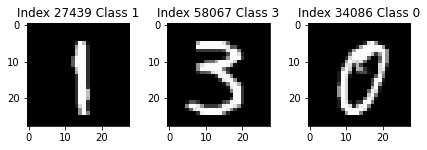

In [6]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

# Important
* Always have a validation set, the procedure to create validation or dev set is by performing random sample without replacement on train set and then only using that fraction as dev set. 
* Simple approach is to set some K samples, you can extract them from start, mid or end.
* Imagine validation set that partially approximates test set distribution and we assume our model would produce identical results when we test it on test set.
* Always optimize your hyperparameters by looking at performance on validation set and not test set.
* Do not touch test set, we have this to test how our model would work on unseen data.

In [7]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


# Points to remember
* If using any type of neural network, normalize your input between 0-1.
* One can use various procedures to achieve this, divide by largest value (for images we use 255), subtract mean from data and then normalize, one can even augment them and use other steps for normalization.
* Normalization is important step, one could observe significant boost in performance just by having better normalization scheme.
* For targets we always use one-hot encodings.

In [8]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [9]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# Importance of weight initialization

* One reason backprop based models can perform bettter lies with the weight initialization method, one important point one should remember is that, if yur weights are initialized to be too high or low, backprop would struggle.
* Hence one should always carefully initialize weights of your model, below i have shown approach with random_normal, one can use random_uniform, truncated version of both, Xavier init and orthogonal. 
* You will find modern day NNs have achieved stable and better performance by simply switching to better init and majority of cases Xavier or Orthogonal works best.
* Always initialize your bias using zero or some small constant (ideally 0.01 or less works better). We use bias to shift the activation and in some cases it can stabalize learning, but having large bias can cause negative results.

# Loss function

* We will always cross-entropy loss for classification.

* tf softmax,
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf)), this function is simply saying that it will calculate softmax for you, simply provide logits to it. 

* In other output of your forward pass directly goes this function. Now this operator will calculate or apply softmax over prediction or logits and calculate cross-entropy between prediction and target. I am using reduce_mean since we apply this over batches.
* Second is using keras
Method 1 :- This function requires logits, hence same as above you will pass logits or output variable to this function. Now remember you need from_logits = True, for this to work.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss_x = cce(y_true_tf, y_pred_tf) 

* Method 2:- In this we will apply softmax to output function and then pass to CCE loss.
So the approach is 
output = tf.nn.softmax(output)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_x = cce(y_true_tf, y_pred_tf) 

In [138]:
import math
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

    # self.m = tf.Variable(tf.zeros([1,8]))
    # self.v = tf.Variable(tf.zeros([1,8]))
    # self.u = tf.Variable(tf.zeros([1,8]))
    self.m = [0.]*len(self.variables)
    self.v = [0.]*len(self.variables)
    self.u = [0.]*len(self.variables)
    self.t = 0


 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train, optim_type="Adam"):
    """
    backward pass
    """
    # optim = tf.keras.optimizers.RMSprop(learning_rate = 1e-3)
    # optim = tf.keras.optimizers.SGD(learning_rate = 1e-3)
    # optim = tf.keras.optimizers.Adam(learning_rate = 1e-3)  
    """
    backward pass
    """

    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)

    grads = tape.gradient(current_loss, self.variables)

    if optim_type == "RMS":
      optim = tf.keras.optimizers.RMSprop(learning_rate = 1e-5)
      optim.apply_gradients(zip(grads, self.variables))
    elif optim_type == "SGD":

      optim = tf.keras.optimizers.SGD(learning_rate = 1e-2)
      optim.apply_gradients(zip(grads, self.variables))
    elif optim_type == "Adam":
      optim = tf.keras.optimizers.Adam(learning_rate = 1e-4)
      optim.apply_gradients(zip(grads, self.variables)) 
    else:
      lr = 1e-3
      beta_1 = 0.9
      beta_2 = 0.999
      beta_3 = 0.999987
      epsilon = 1e-8
      epsilon_2 = 1e-6
      dws = grads
      self.t = self.t + 1
      self.m = [beta_1 * a_i + (1-beta_1) * b_i for a_i, b_i in zip(self.m, dws)]
      dws2 = [i*i for i in dws]
      self.v = [beta_2 * a_i + (1-beta_2) * b_i for a_i, b_i in zip(self.m, dws2)]
      dws3 = [i*i*1 for i in dws]
      self.u = [beta_3 * a_i + (1-beta_3) * b_i for a_i, b_i in zip(self.m, dws3)]

      m_t = [i / (1 - math.pow(beta_1, self.t)) for i in self.m]
      v_t = [i / (1 - math.pow(beta_2, self.t)) for i in self.v]
      u_t = [i / (1 - math.pow(beta_3, self.t)) for i in self.u]

      # r_t = self.variables - lr * m_t / (tf.sqrt(v_t) + (tf.pow(u_t, 1/3)*epsilon+ epsilon_2))
      for i in range(len(self.variables)):
        r_t = self.variables[i] - lr * m_t[i] / (tf.math.sqrt(tf.math.abs(v_t[i])) + (tf.math.sign(u_t[i]) * tf.math.pow(tf.math.abs(u_t[i]), 1/3)*epsilon+ epsilon_2))
        self.variables[i].assign(r_t)

           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)

 def stderr(self,y_pred):
    """
     Calculate standard error
     """
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    std_err = std_dev/math.sqrt(len(y_pred_tf))
    return std_err 


 def var(self,y_pred):
    """
     Calculate variance 
     """
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    variance = (std_dev**2) # calculate variance
    return variance 



  5%|▌         | 1/20 [00:28<09:08, 28.87s/it]


Train Accuracy: 0.8736
Number of Epoch = 1 - Average Cross Entropy:= 0.008230970458984375 - Stderr:=0.001097048380446513 - Var:= 0.060175757452015866 

Validation Accuracy: 0.8869


 10%|█         | 2/20 [00:46<06:43, 22.42s/it]


Train Accuracy: 0.9063
Number of Epoch = 2 - Average Cross Entropy:= 0.002912568054199219 - Stderr:=0.0011994375705292272 - Var:= 0.07193252427985275 

Validation Accuracy: 0.9160


 15%|█▌        | 3/20 [01:02<05:30, 19.45s/it]


Train Accuracy: 0.9203
Number of Epoch = 3 - Average Cross Entropy:= 0.002306922912597656 - Stderr:=0.0012316041744578924 - Var:= 0.07584244212710534 

Validation Accuracy: 0.9284


 20%|██        | 4/20 [01:18<04:46, 17.91s/it]


Train Accuracy: 0.9297
Number of Epoch = 4 - Average Cross Entropy:= 0.0020092095947265623 - Stderr:=0.0012490261411187997 - Var:= 0.07800331505990599 

Validation Accuracy: 0.9353


 25%|██▌       | 5/20 [01:33<04:16, 17.11s/it]


Train Accuracy: 0.9357
Number of Epoch = 5 - Average Cross Entropy:= 0.0018096112060546875 - Stderr:=0.0012591703513324289 - Var:= 0.07927549868373163 

Validation Accuracy: 0.9415


 30%|███       | 6/20 [01:49<03:51, 16.54s/it]


Train Accuracy: 0.9404
Number of Epoch = 6 - Average Cross Entropy:= 0.001660638885498047 - Stderr:=0.001268314561424752 - Var:= 0.08043109133610304 

Validation Accuracy: 0.9457


 35%|███▌      | 7/20 [02:10<03:54, 18.01s/it]


Train Accuracy: 0.9450
Number of Epoch = 7 - Average Cross Entropy:= 0.0015416302490234375 - Stderr:=0.001274898461996844 - Var:= 0.08126830442009592 

Validation Accuracy: 0.9488


 40%|████      | 8/20 [02:31<03:47, 18.99s/it]


Train Accuracy: 0.9484
Number of Epoch = 8 - Average Cross Entropy:= 0.0014470103454589844 - Stderr:=0.0012802841750318786 - Var:= 0.08195637844185288 

Validation Accuracy: 0.9508


 45%|████▌     | 9/20 [02:52<03:36, 19.64s/it]


Train Accuracy: 0.9516
Number of Epoch = 9 - Average Cross Entropy:= 0.0013598387145996095 - Stderr:=0.001284996024197351 - Var:= 0.08256073911014994 

Validation Accuracy: 0.9534


 50%|█████     | 10/20 [03:08<03:04, 18.49s/it]


Train Accuracy: 0.9537
Number of Epoch = 10 - Average Cross Entropy:= 0.0012856515502929688 - Stderr:=0.0012892210013858631 - Var:= 0.08310453952071839 

Validation Accuracy: 0.9550


 55%|█████▌    | 11/20 [03:29<02:53, 19.25s/it]


Train Accuracy: 0.9559
Number of Epoch = 11 - Average Cross Entropy:= 0.0012254828643798827 - Stderr:=0.0012921516961302859 - Var:= 0.08348280029061872 

Validation Accuracy: 0.9573


 60%|██████    | 12/20 [03:50<02:38, 19.79s/it]


Train Accuracy: 0.9583
Number of Epoch = 12 - Average Cross Entropy:= 0.0011703846740722657 - Stderr:=0.0012952218017939256 - Var:= 0.08387997579211515 

Validation Accuracy: 0.9581


 65%|██████▌   | 13/20 [04:11<02:21, 20.15s/it]


Train Accuracy: 0.9599
Number of Epoch = 13 - Average Cross Entropy:= 0.001123309326171875 - Stderr:=0.0012978763403006636 - Var:= 0.08422414973561221 

Validation Accuracy: 0.9591


 70%|███████   | 14/20 [04:32<02:02, 20.41s/it]


Train Accuracy: 0.9615
Number of Epoch = 14 - Average Cross Entropy:= 0.0010797169494628906 - Stderr:=0.0012998160979663296 - Var:= 0.08447609442662074 

Validation Accuracy: 0.9610


 75%|███████▌  | 15/20 [04:48<01:34, 18.99s/it]


Train Accuracy: 0.9631
Number of Epoch = 15 - Average Cross Entropy:= 0.0010396584320068358 - Stderr:=0.0013026828182927557 - Var:= 0.08484912625375785 

Validation Accuracy: 0.9620


 80%|████████  | 16/20 [05:09<01:18, 19.61s/it]


Train Accuracy: 0.9651
Number of Epoch = 16 - Average Cross Entropy:= 0.0010053260040283204 - Stderr:=0.0013043554827632867 - Var:= 0.08506716127073233 

Validation Accuracy: 0.9622


 85%|████████▌ | 17/20 [05:24<00:55, 18.35s/it]


Train Accuracy: 0.9660
Number of Epoch = 17 - Average Cross Entropy:= 0.0009697953796386719 - Stderr:=0.0013066478994081577 - Var:= 0.08536643665138754 

Validation Accuracy: 0.9625


 90%|█████████ | 18/20 [05:45<00:38, 19.14s/it]


Train Accuracy: 0.9672
Number of Epoch = 18 - Average Cross Entropy:= 0.0009420309448242187 - Stderr:=0.0013075773943896304 - Var:= 0.08548793211593875 

Validation Accuracy: 0.9631


 95%|█████████▌| 19/20 [06:06<00:19, 19.70s/it]


Train Accuracy: 0.9684
Number of Epoch = 19 - Average Cross Entropy:= 0.000914976577758789 - Stderr:=0.0013096116476018784 - Var:= 0.08575413337672533 

Validation Accuracy: 0.9637


100%|██████████| 20/20 [06:22<00:00, 19.13s/it]


Train Accuracy: 0.9696
Number of Epoch = 20 - Average Cross Entropy:= 0.0008937312316894531 - Stderr:=0.0013110572028885222 - Var:= 0.08594354946229377 

Validation Accuracy: 0.9640

Total time taken (in seconds): 382.57


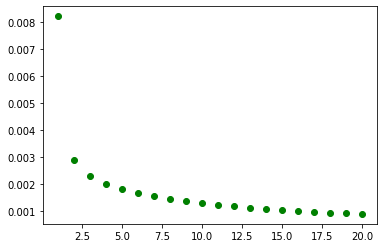

In [161]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()

for epoch in tqdm(range(NUM_EPOCHS)):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs, "Adam")

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  stderr = mlp_on_cpu.stderr(preds)
  var = mlp_on_cpu.var(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} - Stderr:={} - Var:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0], stderr, var))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [162]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.4f}'.format(cur_test_acc))


Test loss: 0.0332

Test Accuracy: 0.9613
